# Training simple neural networks on the MNIST dataset using keras

### Setting up your environment

You can create a suitable conda environment to run this notebook using:

    conda create -n keras_demo python=3 tensorflow matplotlib ipykernel scikit-learn pandas
    
Use `tensorflow-gpu` if you have a suitable GPU. If you have a GPU but haven't got the latest cuda drivers installed, you may also need to specify `cudatoolkit=9.0` or similar.

You may need to use `pip` to install the latest version of tensorflow and/or in an existing environment.

### First some common imports...

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Set up TensorFlow in a friendly manner

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        # Turn on memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            #tf.config.experimental.set_virtual_device_configuration(gpu,
            #      [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(logical_gpus)
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print(f'Tensorflow using CPU')

Tensorflow using CPU


In [3]:
# check that we have the devices we expect available
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16500109075104841715,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1949301378266683509
 physical_device_desc: "device: XLA_CPU device"]

### Import keras bits and pieces

In [4]:
# if you have a recent version of tensorflow, keras is included
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

### We will use a standard demonstration data set: MNIST handwritten digits

In [5]:
# the data, split between train and test sets
(x_train, y_train), (x_valtest, y_valtest) = mnist.load_data()

In [6]:
# demo the effect of noisy data
#x_train = (x_train/5 + np.random.poisson(200, size=x_train.shape)).clip(0, 255)
#x_valtest = (x_valtest/5 + np.random.poisson(200, size=x_valtest.shape)).clip(0, 255)

In [7]:
# if we wanted to test our model on limited data,
# we could reduce the amount of training data like this...
idx = np.random.choice(len(x_train), size=len(x_train)//100)
x_train = x_train[idx]
y_train = y_train[idx]

If your data isn't split, or want a validation set, need to do split manually

In [8]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_valtest, y_valtest, test_size=0.5)

In [9]:
x_train.shape, y_train.shape

((600, 28, 28), (600,))

In [10]:
x_test.shape, y_test.shape

((5000, 28, 28), (5000,))

In [11]:
x_val.shape, y_val.shape

((5000, 28, 28), (5000,))

### Take a look at the data

This is a very quick glance - you should carefully examine any new dataset

class = 6


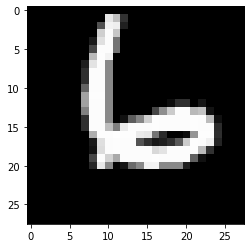

In [12]:
i = 3
plt.imshow(x_train[i], cmap='gray')
print('class =', y_train[i])

### Prepare the data

In [13]:
# convert class vectors to "one-hot" binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [14]:
y_train[i]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [15]:
def process_data(x):
    x = x.reshape(-1, 784)
    x = x.astype('float32')
    x /= 255
    return x

In [16]:
x_train = process_data(x_train)
x_test = process_data(x_test)
x_val = process_data(x_val)

In [17]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

600 train samples
5000 test samples
5000 validation samples


## Fully-connected NN

### Construct the network

In [18]:
# a fairly small network for speed
fcmodel = Sequential()
fcmodel.add(Dense(32, activation='relu', input_shape=(784,)))
fcmodel.add(Dense(32, activation='relu'))
# could include dropout, regularisation, ...
fcmodel.add(Dense(num_classes, activation='softmax'))

In [19]:
fcmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [20]:
fcmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

### Train the network

In [21]:
batch_size = 32
epochs = 50

In [22]:
history = fcmodel.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=2,
                      validation_data=(x_test, y_test))

Epoch 1/50
19/19 - 0s - loss: 2.1203 - accuracy: 0.3167 - val_loss: 1.8732 - val_accuracy: 0.4916
Epoch 2/50
19/19 - 0s - loss: 1.6130 - accuracy: 0.5950 - val_loss: 1.4068 - val_accuracy: 0.6322
Epoch 3/50
19/19 - 0s - loss: 1.1690 - accuracy: 0.6967 - val_loss: 1.0472 - val_accuracy: 0.7270
Epoch 4/50
19/19 - 0s - loss: 0.8661 - accuracy: 0.8100 - val_loss: 0.8371 - val_accuracy: 0.7820
Epoch 5/50
19/19 - 0s - loss: 0.6799 - accuracy: 0.8467 - val_loss: 0.7074 - val_accuracy: 0.8048
Epoch 6/50
19/19 - 0s - loss: 0.5541 - accuracy: 0.8733 - val_loss: 0.6255 - val_accuracy: 0.8164
Epoch 7/50
19/19 - 0s - loss: 0.4573 - accuracy: 0.9017 - val_loss: 0.5838 - val_accuracy: 0.8244
Epoch 8/50
19/19 - 0s - loss: 0.3848 - accuracy: 0.9150 - val_loss: 0.5486 - val_accuracy: 0.8326
Epoch 9/50
19/19 - 0s - loss: 0.3239 - accuracy: 0.9267 - val_loss: 0.5370 - val_accuracy: 0.8348
Epoch 10/50
19/19 - 0s - loss: 0.2778 - accuracy: 0.9450 - val_loss: 0.4895 - val_accuracy: 0.8470
Epoch 11/50
19/19 -

In [23]:
score = fcmodel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8338583111763
Test accuracy: 0.8740000128746033


In [24]:
# really we should not look at the score for this set of data
# until we have finished tuning our model
score = fcmodel.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9034996032714844
Test accuracy: 0.8669999837875366


In [25]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss', 'val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy', 'val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_acc) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

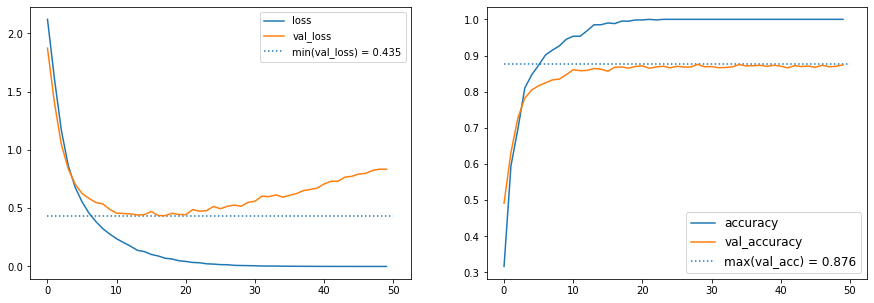

In [27]:
histplot(history)

## Convolutional Neural Network (CNN)

### Reshape the data

In [28]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

### Construct the network

In [29]:
# a fairly small network for speed
cnnmodel = Sequential()
cnnmodel.add(Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnnmodel.add(MaxPooling2D((3, 3)))
cnnmodel.add(Conv2D(16, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(num_classes, activation='softmax'))
# could include dropout, regularisation, ...

In [30]:
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

In [31]:
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1450      
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
____________________________________________________

In [32]:
# save weights for reinitialising below
cnnmodel.save_weights('/tmp/cnnmodel_init_weights.tf')

### Train the network

In [33]:
history = cnnmodel.fit(x_train, y_train,
                       batch_size=batch_size, 
                       epochs=3*epochs,
                       verbose=2,
                       validation_data=(x_test, y_test))

Epoch 1/150
19/19 - 0s - loss: 2.2533 - accuracy: 0.2233 - val_loss: 2.1837 - val_accuracy: 0.3164
Epoch 2/150
19/19 - 0s - loss: 2.1125 - accuracy: 0.4150 - val_loss: 2.0330 - val_accuracy: 0.4650
Epoch 3/150
19/19 - 0s - loss: 1.9279 - accuracy: 0.5233 - val_loss: 1.8292 - val_accuracy: 0.5332
Epoch 4/150
19/19 - 0s - loss: 1.6959 - accuracy: 0.6000 - val_loss: 1.5860 - val_accuracy: 0.6526
Epoch 5/150
19/19 - 0s - loss: 1.4415 - accuracy: 0.6550 - val_loss: 1.3671 - val_accuracy: 0.6836
Epoch 6/150
19/19 - 0s - loss: 1.2214 - accuracy: 0.6717 - val_loss: 1.1484 - val_accuracy: 0.7236
Epoch 7/150
19/19 - 0s - loss: 1.0278 - accuracy: 0.7267 - val_loss: 0.9680 - val_accuracy: 0.7508
Epoch 8/150
19/19 - 0s - loss: 0.8894 - accuracy: 0.7583 - val_loss: 0.8476 - val_accuracy: 0.7908
Epoch 9/150
19/19 - 0s - loss: 0.7698 - accuracy: 0.8033 - val_loss: 0.7483 - val_accuracy: 0.7976
Epoch 10/150
19/19 - 0s - loss: 0.6882 - accuracy: 0.8100 - val_loss: 0.6954 - val_accuracy: 0.8020
Epoch 11/

19/19 - 0s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.4037 - val_accuracy: 0.9130
Epoch 84/150
19/19 - 0s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.4557 - val_accuracy: 0.9020
Epoch 85/150
19/19 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.4306 - val_accuracy: 0.9096
Epoch 86/150
19/19 - 0s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.4393 - val_accuracy: 0.9066
Epoch 87/150
19/19 - 0s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.4544 - val_accuracy: 0.9084
Epoch 88/150
19/19 - 0s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.4478 - val_accuracy: 0.9074
Epoch 89/150
19/19 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.4420 - val_accuracy: 0.9076
Epoch 90/150
19/19 - 0s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.4525 - val_accuracy: 0.9098
Epoch 91/150
19/19 - 0s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.4475 - val_accuracy: 0.9080
Epoch 92/150
19/19 - 0s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4484 - val_accuracy: 0.9130
Epoch 93/150


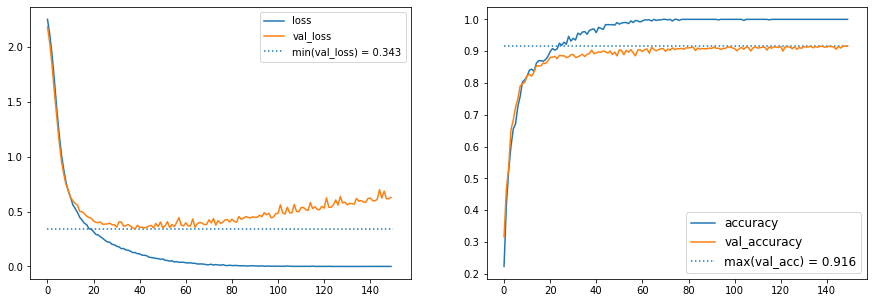

In [34]:
histplot(history)

## Online data augmentation

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=20.0,
    zoom_range=0.05)

#datagen.fit(x_train)  # only required if normalizing

In [36]:
gen = datagen.flow(x_train, y_train, batch_size=1)

label = 6


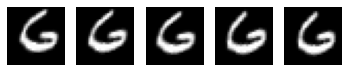

In [37]:
# run this several times to see more augmented examples
i = 3
fig, axarr = plt.subplots(1, 5)
for ax in axarr:
    img = gen[i][0][0, : , :, 0]
    ax.imshow(img, cmap='gray');
    ax.axis('off')
print('label =', gen[i][1][0].argmax())

In [38]:
# Reinitialise model
cnnmodel.load_weights('/tmp/cnnmodel_init_weights.tf')

In [39]:
cnnmodel.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(),
                 metrics=['accuracy'])

In [40]:
# fits the model on batches with real-time data augmentation:
# the accuracy continues to (slowly) rise, due to the augmentation
history = cnnmodel.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                 epochs=3*epochs,
                                 verbose=2,
                                 validation_data=(x_test, y_test))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
19/19 - 1s - loss: 2.2831 - accuracy: 0.1750 - val_loss: 2.2411 - val_accuracy: 0.2534
Epoch 2/150
19/19 - 0s - loss: 2.1964 - accuracy: 0.2817 - val_loss: 2.1361 - val_accuracy: 0.3636
Epoch 3/150
19/19 - 0s - loss: 2.0824 - accuracy: 0.3600 - val_loss: 1.9735 - val_accuracy: 0.4372
Epoch 4/150
19/19 - 0s - loss: 1.9328 - accuracy: 0.4333 - val_loss: 1.7767 - val_accuracy: 0.5244
Epoch 5/150
19/19 - 0s - loss: 1.7491 - accuracy: 0.4933 - val_loss: 1.5545 - val_accuracy: 0.6164
Epoch 6/150
19/19 - 0s - loss: 1.5649 - accuracy: 0.5767 - val_loss: 1.3354 - val_accuracy: 0.6626
Epoch 7/150
19/19 - 0s - loss: 1.3767 - accuracy: 0.6183 - val_loss: 1.1398 - val_accuracy: 0.7206
Epoch 8/150
19/19 - 0s - loss: 1.2323 - accuracy: 0.6350 - val_loss: 1.0164 - val_accuracy: 0.7386
Epoch 9/150
19/19 - 0s - loss: 1.1056 - accuracy: 0.6800 - val_loss: 0.8845 - val_accuracy: 0.7650
Epoch 10/150
19/19 - 0s - loss: 1

Epoch 81/150
19/19 - 0s - loss: 0.1780 - accuracy: 0.9400 - val_loss: 0.1546 - val_accuracy: 0.9468
Epoch 82/150
19/19 - 0s - loss: 0.2250 - accuracy: 0.9250 - val_loss: 0.1724 - val_accuracy: 0.9434
Epoch 83/150
19/19 - 0s - loss: 0.1954 - accuracy: 0.9383 - val_loss: 0.1616 - val_accuracy: 0.9464
Epoch 84/150
19/19 - 0s - loss: 0.1680 - accuracy: 0.9417 - val_loss: 0.2083 - val_accuracy: 0.9338
Epoch 85/150
19/19 - 0s - loss: 0.2083 - accuracy: 0.9333 - val_loss: 0.1663 - val_accuracy: 0.9458
Epoch 86/150
19/19 - 0s - loss: 0.1795 - accuracy: 0.9450 - val_loss: 0.1493 - val_accuracy: 0.9508
Epoch 87/150
19/19 - 0s - loss: 0.2052 - accuracy: 0.9300 - val_loss: 0.1537 - val_accuracy: 0.9456
Epoch 88/150
19/19 - 0s - loss: 0.1475 - accuracy: 0.9617 - val_loss: 0.1732 - val_accuracy: 0.9408
Epoch 89/150
19/19 - 0s - loss: 0.1903 - accuracy: 0.9433 - val_loss: 0.1605 - val_accuracy: 0.9484
Epoch 90/150
19/19 - 0s - loss: 0.1640 - accuracy: 0.9550 - val_loss: 0.1596 - val_accuracy: 0.9482


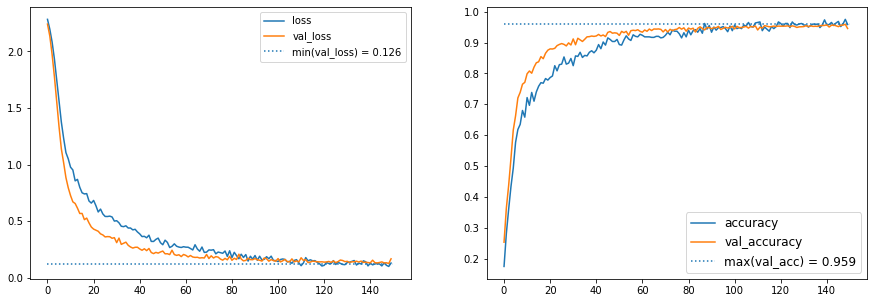

In [41]:
histplot(history)

Data augmentation reduced number of misclassifications by half.